# Basic GAN

Based on the Original Generative Adversarial Networks created by Ian Goodfellow [paper](https://arxiv.org/abs/1406.2661)

GANs are an adversarial fight between 2 networks were the Generator network is being trained to fool the Discriminator network which is also being trainined to detect fake vs real data

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

#### Create the dirs for saving images and saving the model if not there


In [2]:
if not os.path.exists('generated_numbers/'):
    os.makedirs('generated_numbers/')
    
if not os.path.exists('model/'):
    os.makedirs('model/')

### Load Data from MNIST TF Lib

In [3]:

# Import MNIST from TF Examples
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### Xavier Standard Deviation init of weights

After testing this seems to initialize the most stable weights 

Here is an explanation of [Xavier Initialization](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


### The Networks are 2 layer simple MLPs

**Discriminator Network**  
the discriminator takes 784 inputs in  
in = 784  
hidden_layer_1 = 128  
output_layer = 1  
 
**Generator Network**  
the generator networks takes 100 inputs in  
in = 100  
hidden_layer_1 = 128  
output_layer = 784  

In [5]:
#Input placeholder - 784 for MNIST image
X = tf.placeholder(tf.float32, shape=[None, 784])

# Discriminator Weights and biases
Dis_W1 = tf.Variable(xavier_init([784, 128]),name='Dis_W1')  
Dis_b1 = tf.Variable(tf.zeros(shape=[128]),name='Dis_b1')

Dis_W2 = tf.Variable(xavier_init([128, 1]),name='Dis_W2')
Dis_b2 = tf.Variable(tf.zeros(shape=[1]),name='Dis_b2')

#this is what gets changed by the D_Optimizer
Dis_weights = [Dis_W1, Dis_W2, Dis_b1, Dis_b2]

In [6]:
#input for Generator network
Z = tf.placeholder(tf.float32, shape=[None, 100])

# Generator Weights and biases
Gen_W1 = tf.Variable(xavier_init([100, 128]),name='Gen_W1')
Gen_b1 = tf.Variable(tf.zeros(shape=[128]),name='Gen_b1')

Gen_W2 = tf.Variable(xavier_init([128, 784]),name='Gen_W2')
Gen_b2 = tf.Variable(tf.zeros(shape=[784]),name='Gen_b2')

#this is what gets changed by the G_Optimizer
Gen_weights = [Gen_W1, Gen_W2, Gen_b1, Gen_b2]

### Create Noise for Generator network


In [7]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


### Generator network

In [8]:
def generator(z):
    Gen_h1 = tf.nn.relu(tf.matmul(z, Gen_W1) + Gen_b1)
    Gen_logits = tf.matmul(Gen_h1, Gen_W2) + Gen_b2
    Gen_prob = tf.nn.sigmoid(Gen_logits)

    return Gen_prob

### Discriminator Network

This returns a prob result and the logits level that was used to derive that probability


In [9]:
def discriminator(x):
    Dis_h1 = tf.nn.relu(tf.matmul(x, Dis_W1) + Dis_b1)
    Dis_logits = tf.matmul(Dis_h1, Dis_W2) + Dis_b2
    Dis_prob = tf.nn.sigmoid(Dis_logits)

    return Dis_prob, Dis_logits

### Plot the images generated

In [10]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

### Make the samples

In [11]:
# G_sample = generated sample from gen network using z input
G_sample = generator(Z)

# D_real is made with a real MNIST example
D_real, D_logit_real = discriminator(X)

#D_fake is made with generated sample from Gen Network
D_fake, D_logit_fake = discriminator(G_sample)


### Losses

1. D_loss_real is the loss from a real image
2. D_loss_fake is the loss from a generated image
3. D_loss is the overall Discriminator loss from real and fake summed together
4. G_loss is generator loss

In [12]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

### Optimizers

Standard Adam optimizers  
D_optimizer is minimizing overall D_loss


In [13]:
D_optimizer = tf.train.AdamOptimizer(learning_rate=0.001,name = 'D_Optimizer').minimize(D_loss, var_list=Dis_weights)
G_optimizer = tf.train.AdamOptimizer(learning_rate=0.001,name = 'G_Optimizer').minimize(G_loss, var_list=Gen_weights)

In [14]:
# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# path for saving
model_path = "./model/GAN_model1.ckpt"

In [20]:
# mini batch size
mb_size = 128 

# Z size for random noise generation
Z_dim = 100 

# Initializing the variables
init = tf.global_variables_initializer()

In [21]:
sess = tf.Session()
sess.run(init)

## The train loop





Iteration: 0
Dis loss: 1.174
Gen_loss: 2.604

Model saved to: ./model/GAN_model1.ckpt
Iteration: 1000
Dis loss: 0.01238
Gen_loss: 5.914

Model saved to: ./model/GAN_model1.ckpt
Iteration: 2000
Dis loss: 0.1322
Gen_loss: 4.177

Model saved to: ./model/GAN_model1.ckpt
Iteration: 3000
Dis loss: 0.1068
Gen_loss: 5.718

Model saved to: ./model/GAN_model1.ckpt
Iteration: 4000
Dis loss: 0.1233
Gen_loss: 5.929

Model saved to: ./model/GAN_model1.ckpt
Iteration: 5000
Dis loss: 0.2061
Gen_loss: 5.079

Model saved to: ./model/GAN_model1.ckpt
Iteration: 6000
Dis loss: 0.3526
Gen_loss: 3.917

Model saved to: ./model/GAN_model1.ckpt
Iteration: 7000
Dis loss: 0.4867
Gen_loss: 3.786

Model saved to: ./model/GAN_model1.ckpt
Iteration: 8000
Dis loss: 0.6311
Gen_loss: 3.499

Model saved to: ./model/GAN_model1.ckpt
Iteration: 9000
Dis loss: 0.5649
Gen_loss: 2.583

Model saved to: ./model/GAN_model1.ckpt
Iteration: 10000
Dis loss: 0.4147
Gen_loss: 2.98

Model saved to: ./model/GAN_model1.ckpt
Iteration: 11

Iteration: 91000
Dis loss: 0.5887
Gen_loss: 2.576

Model saved to: ./model/GAN_model1.ckpt
Iteration: 92000
Dis loss: 0.5079
Gen_loss: 2.593

Model saved to: ./model/GAN_model1.ckpt
Iteration: 93000
Dis loss: 0.5025
Gen_loss: 2.908

Model saved to: ./model/GAN_model1.ckpt
Iteration: 94000
Dis loss: 0.4205
Gen_loss: 2.544

Model saved to: ./model/GAN_model1.ckpt
Iteration: 95000
Dis loss: 0.5346
Gen_loss: 2.932

Model saved to: ./model/GAN_model1.ckpt
Iteration: 96000
Dis loss: 0.4445
Gen_loss: 2.608

Model saved to: ./model/GAN_model1.ckpt
Iteration: 97000
Dis loss: 0.5278
Gen_loss: 2.639

Model saved to: ./model/GAN_model1.ckpt
Iteration: 98000
Dis loss: 0.4833
Gen_loss: 2.911

Model saved to: ./model/GAN_model1.ckpt
Iteration: 99000
Dis loss: 0.521
Gen_loss: 3.129

Model saved to: ./model/GAN_model1.ckpt
Iteration: 100000
Dis loss: 0.4134
Gen_loss: 2.809

Model saved to: ./model/GAN_model1.ckpt
Iteration: 101000
Dis loss: 0.5246
Gen_loss: 2.783

Model saved to: ./model/GAN_model1.ckp

Iteration: 181000
Dis loss: 0.3369
Gen_loss: 2.886

Model saved to: ./model/GAN_model1.ckpt
Iteration: 182000
Dis loss: 0.3136
Gen_loss: 3.265

Model saved to: ./model/GAN_model1.ckpt
Iteration: 183000
Dis loss: 0.3073
Gen_loss: 3.287

Model saved to: ./model/GAN_model1.ckpt
Iteration: 184000
Dis loss: 0.2974
Gen_loss: 3.006

Model saved to: ./model/GAN_model1.ckpt
Iteration: 185000
Dis loss: 0.3921
Gen_loss: 3.664

Model saved to: ./model/GAN_model1.ckpt
Iteration: 186000
Dis loss: 0.4001
Gen_loss: 3.261

Model saved to: ./model/GAN_model1.ckpt
Iteration: 187000
Dis loss: 0.4301
Gen_loss: 2.708

Model saved to: ./model/GAN_model1.ckpt
Iteration: 188000
Dis loss: 0.3534
Gen_loss: 3.095

Model saved to: ./model/GAN_model1.ckpt
Iteration: 189000
Dis loss: 0.3312
Gen_loss: 2.65

Model saved to: ./model/GAN_model1.ckpt
Iteration: 190000
Dis loss: 0.3043
Gen_loss: 3.27

Model saved to: ./model/GAN_model1.ckpt


/home/dennis/anaconda3/envs/cv-nd/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iteration: 191000
Dis loss: 0.402
Gen_loss: 3.01

Model saved to: ./model/GAN_model1.ckpt
Iteration: 192000
Dis loss: 0.4782
Gen_loss: 3.125

Model saved to: ./model/GAN_model1.ckpt
Iteration: 193000
Dis loss: 0.2715
Gen_loss: 2.929

Model saved to: ./model/GAN_model1.ckpt
Iteration: 194000
Dis loss: 0.3325
Gen_loss: 2.705

Model saved to: ./model/GAN_model1.ckpt
Iteration: 195000
Dis loss: 0.3708
Gen_loss: 2.825

Model saved to: ./model/GAN_model1.ckpt
Iteration: 196000
Dis loss: 0.4596
Gen_loss: 3.258

Model saved to: ./model/GAN_model1.ckpt
Iteration: 197000
Dis loss: 0.2549
Gen_loss: 3.363

Model saved to: ./model/GAN_model1.ckpt
Iteration: 198000
Dis loss: 0.3344
Gen_loss: 3.287

Model saved to: ./model/GAN_model1.ckpt
Iteration: 199000
Dis loss: 0.3791
Gen_loss: 3.101

Model saved to: ./model/GAN_model1.ckpt
Iteration: 200000
Dis loss: 0.3263
Gen_loss: 2.581

Model saved to: ./model/GAN_model1.ckpt
Iteration: 201000
Dis loss: 0.3632
Gen_loss: 3.746

Model saved to: ./model/GAN_mo

Iteration: 281000
Dis loss: 0.2338
Gen_loss: 3.102

Model saved to: ./model/GAN_model1.ckpt
Iteration: 282000
Dis loss: 0.2877
Gen_loss: 3.003

Model saved to: ./model/GAN_model1.ckpt
Iteration: 283000
Dis loss: 0.2095
Gen_loss: 3.189

Model saved to: ./model/GAN_model1.ckpt
Iteration: 284000
Dis loss: 0.1967
Gen_loss: 3.254

Model saved to: ./model/GAN_model1.ckpt
Iteration: 285000
Dis loss: 0.2447
Gen_loss: 3.177

Model saved to: ./model/GAN_model1.ckpt
Iteration: 286000
Dis loss: 0.2451
Gen_loss: 2.924

Model saved to: ./model/GAN_model1.ckpt
Iteration: 287000
Dis loss: 0.2837
Gen_loss: 2.835

Model saved to: ./model/GAN_model1.ckpt
Iteration: 288000
Dis loss: 0.2814
Gen_loss: 3.087

Model saved to: ./model/GAN_model1.ckpt
Iteration: 289000
Dis loss: 0.2174
Gen_loss: 2.868

Model saved to: ./model/GAN_model1.ckpt
Iteration: 290000
Dis loss: 0.3528
Gen_loss: 2.878

Model saved to: ./model/GAN_model1.ckpt
Iteration: 291000
Dis loss: 0.2678
Gen_loss: 3.32

Model saved to: ./model/GAN_m

Iteration: 371000
Dis loss: 0.3242
Gen_loss: 3.248

Model saved to: ./model/GAN_model1.ckpt
Iteration: 372000
Dis loss: 0.2564
Gen_loss: 3.435

Model saved to: ./model/GAN_model1.ckpt
Iteration: 373000
Dis loss: 0.1964
Gen_loss: 3.499

Model saved to: ./model/GAN_model1.ckpt
Iteration: 374000
Dis loss: 0.1936
Gen_loss: 3.072

Model saved to: ./model/GAN_model1.ckpt
Iteration: 375000
Dis loss: 0.2575
Gen_loss: 3.229

Model saved to: ./model/GAN_model1.ckpt
Iteration: 376000
Dis loss: 0.2252
Gen_loss: 3.315

Model saved to: ./model/GAN_model1.ckpt
Iteration: 377000
Dis loss: 0.2246
Gen_loss: 2.647

Model saved to: ./model/GAN_model1.ckpt
Iteration: 378000
Dis loss: 0.2304
Gen_loss: 3.101

Model saved to: ./model/GAN_model1.ckpt
Iteration: 379000
Dis loss: 0.2337
Gen_loss: 3.026

Model saved to: ./model/GAN_model1.ckpt
Iteration: 380000
Dis loss: 0.152
Gen_loss: 3.003

Model saved to: ./model/GAN_model1.ckpt
Iteration: 381000
Dis loss: 0.2081
Gen_loss: 3.223

Model saved to: ./model/GAN_m

Iteration: 461000
Dis loss: 0.1786
Gen_loss: 3.268

Model saved to: ./model/GAN_model1.ckpt
Iteration: 462000
Dis loss: 0.2315
Gen_loss: 3.463

Model saved to: ./model/GAN_model1.ckpt
Iteration: 463000
Dis loss: 0.2215
Gen_loss: 3.549

Model saved to: ./model/GAN_model1.ckpt
Iteration: 464000
Dis loss: 0.2676
Gen_loss: 3.046

Model saved to: ./model/GAN_model1.ckpt
Iteration: 465000
Dis loss: 0.3362
Gen_loss: 3.313

Model saved to: ./model/GAN_model1.ckpt
Iteration: 466000
Dis loss: 0.2388
Gen_loss: 3.079

Model saved to: ./model/GAN_model1.ckpt
Iteration: 467000
Dis loss: 0.2018
Gen_loss: 3.536

Model saved to: ./model/GAN_model1.ckpt
Iteration: 468000
Dis loss: 0.2842
Gen_loss: 3.157

Model saved to: ./model/GAN_model1.ckpt
Iteration: 469000
Dis loss: 0.2788
Gen_loss: 3.56

Model saved to: ./model/GAN_model1.ckpt
Iteration: 470000
Dis loss: 0.1667
Gen_loss: 3.462

Model saved to: ./model/GAN_model1.ckpt
Iteration: 471000
Dis loss: 0.1759
Gen_loss: 3.363

Model saved to: ./model/GAN_m

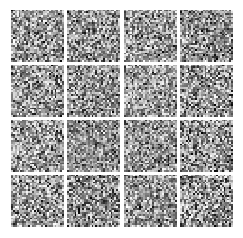

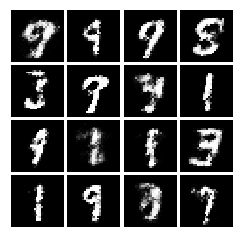

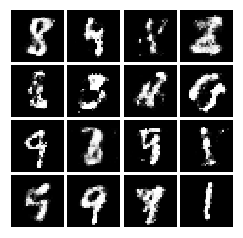

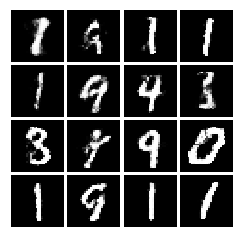

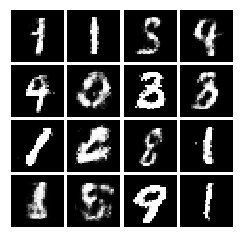

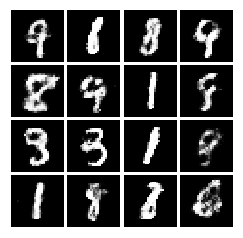

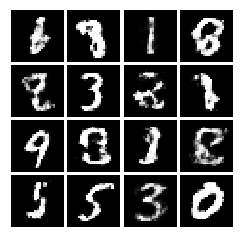

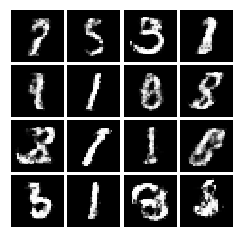

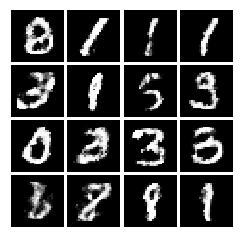

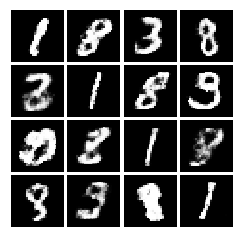

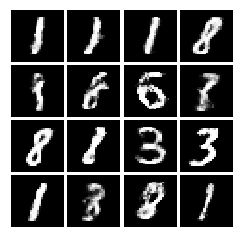

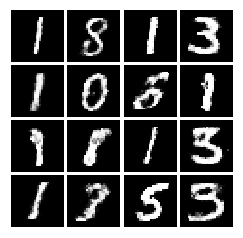

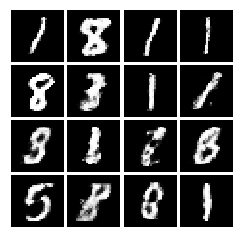

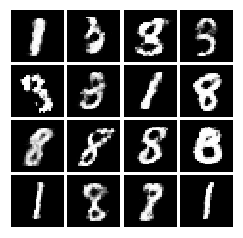

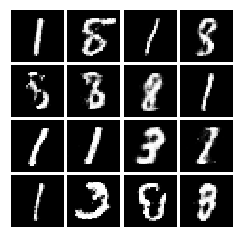

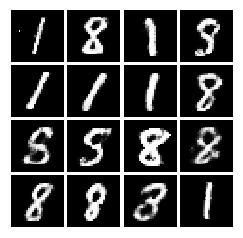

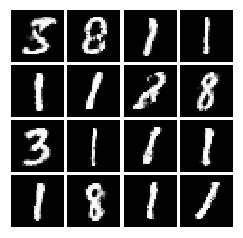

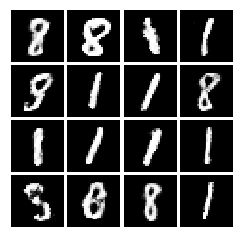

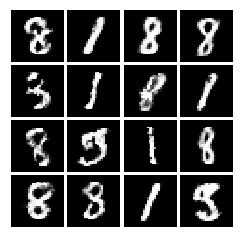

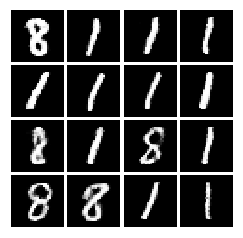

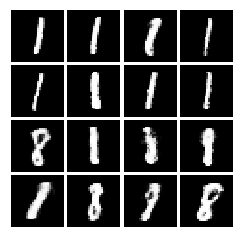

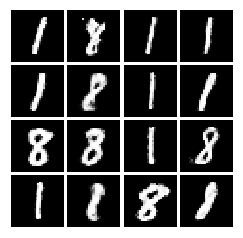

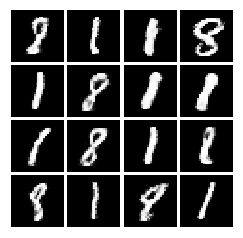

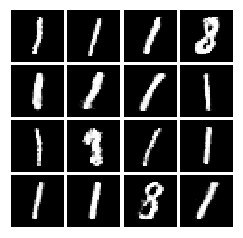

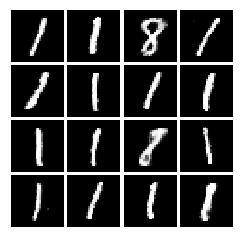

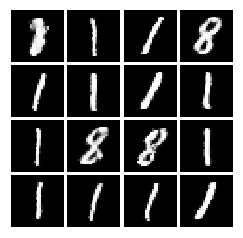

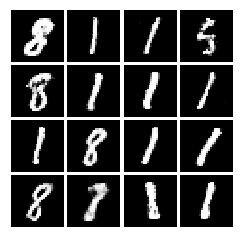

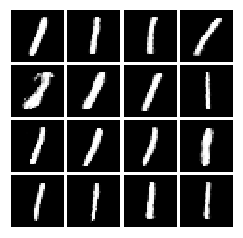

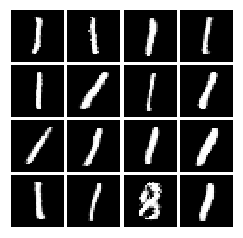

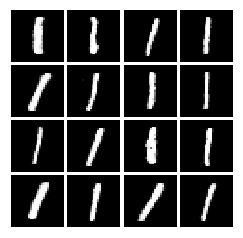

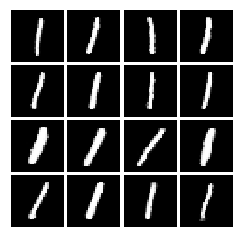

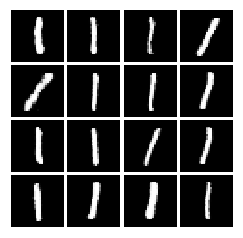

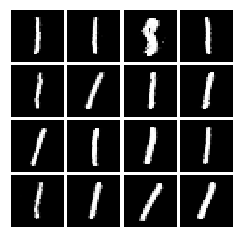

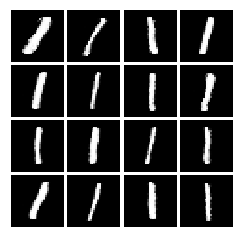

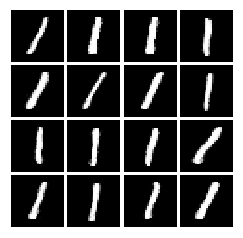

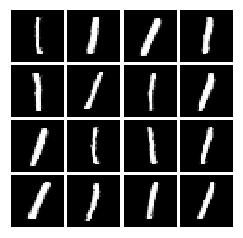

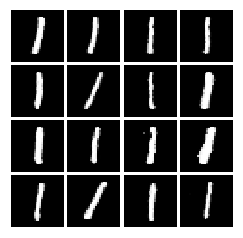

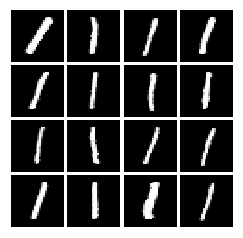

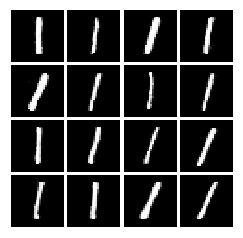

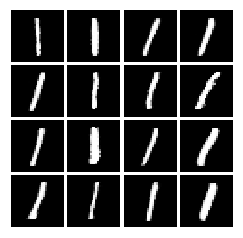

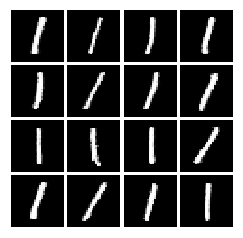

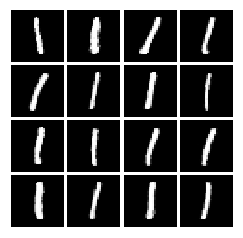

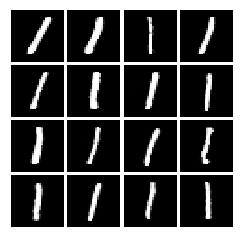

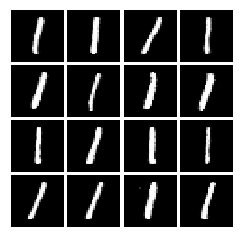

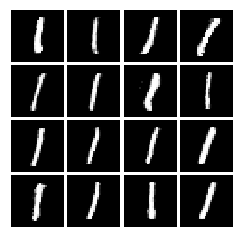

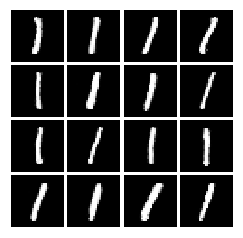

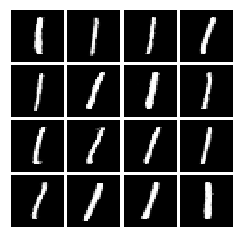

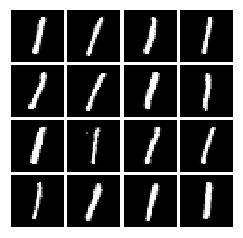

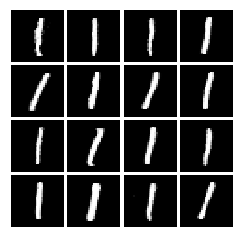

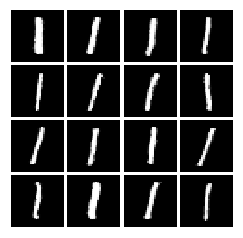

In [22]:

for iteration in range(500000):
    if iteration % 1000 == 0:
        #this makes the 16 images for saving
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        
        # create the image for saving
        fig = plot(samples)
        plt.savefig('generated_numbers/{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
        plt.close(fig)
        
    # get the next mini batch
    X_mb, _ = mnist.train.next_batch(mb_size) 

    _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if iteration % 1000 == 0:
        print('Iteration: {}'.format(iteration))
        print('Dis loss: {:.4}'. format(D_loss_curr))
        print('Gen_loss: {:.4}'.format(G_loss_curr))
        print()
        # Save model weights to disk
        save_path = saver.save(sess, model_path)
        print ("Model saved to: %s" % save_path)
        if iteration %10000==0:
            plot(samples)
            

INFO:tensorflow:Restoring parameters from ./model/GAN_model1.ckpt
Model restored from file: ./model/GAN_model1.ckpt
(16, 784)


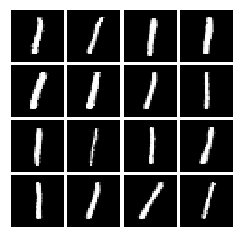

In [25]:
#model_path = "./model-spare/GAN_model1.ckpt"

with tf.Session() as sess:
    sess.run(init)
    
    # Restore model weights from previously saved model
    load_path = saver.restore(sess, model_path)
    print ("Model restored from file: %s" % save_path)
    
    samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, 100)})
    print(samples.shape)
    plot(samples)


### Experiments to try

1. Different weight inits 
2. Add more layers to the 2 networks
3. Add Convolutions to the networks (DCGAN)
4. Try it with different dataset
